In [1]:
import sys
from copy import deepcopy
sys.path.append("../") 

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import LISA as l

import Wavelet as wv
import Glitch as gl
import Glitch_MCMC as glmc
import MCMC_tools as mct
import TDI as td


# constants
mHz = 1.0e-3
Hour = 3600.
Week = 7*24*Hour

In [2]:
Week  = 3600.*24.*7.
dt    = 15.
T     = 2**np.ceil(np.log2(Week/dt))*dt
Orbit = l.Orbit(T, dt=dt) # set up the LISA orbit
print("Nyquist Freq........ {} mHz".format(Orbit.f_ny*1000.))
print("Tobs................ {} days".format(T/Week*7))

A    = 2.0e-20
f0   = 15.0*mHz
tau  = 1.5*Hour
t0   = 0.5*Orbit.Tobs
phi0 = 1.0
print("tau................. {} s".format(tau))
Q = 2*np.pi*f0*tau
print("Q................... {} s".format(Q))
comp_id = 6

paramsND = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0])
glitch = gl.Glitch(paramsND, Orbit, comp_id)

X_flag=None

glitch.calc_TDI()
glitch.calc_snr(X_flag)
glitch.adjust_snr(15, X_flag) # Adjust the SNR to desired target
print("Glitch SNR.......... {}".format(glitch.SNR))
glitch.calc_Fish(X_flag)

print()
e_vals, e_vecs = mct.get_Fisher_Eignen_BS(glitch.Fisher)

modelX0 = glmc.Model(glitch, Orbit)
modelX0.get_loglkl(glitch.TDI, X_flag)
print()
print("modelX0 log L....... {}".format(modelX0.loglkl))

model_true = deepcopy(modelX0)

Nyquist Freq........ 33.333333333333336 mHz
Tobs................ 11.377777777777778 days
tau................. 5400.0 s
Q................... 508.93800988154646 s
Glitch SNR.......... 14.999999999999998


modelX0 log L....... 112.49999999961628


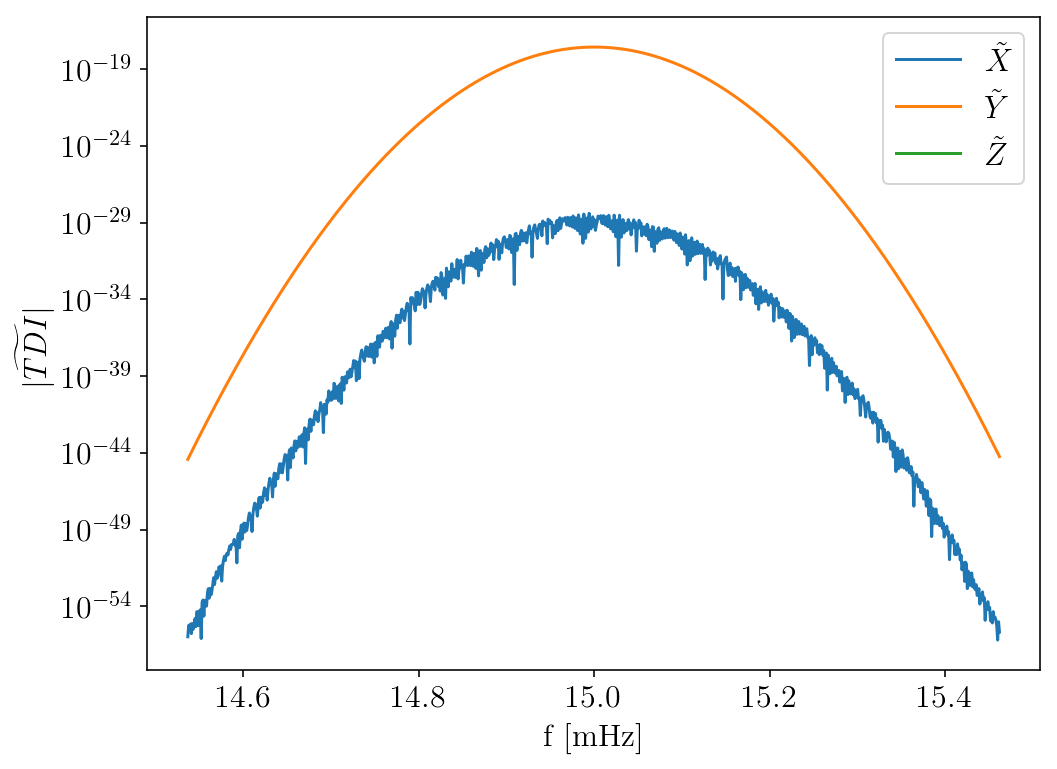

In [3]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r'f [mHz]', fontsize=16)
ax.set_ylabel(r'$|\widetilde{TDI}|$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

f = glitch.TDI.freqs*1000

XX = np.abs(glitch.TDI.X)
YY = np.abs(glitch.TDI.Y)
ZZ = np.abs(glitch.TDI.Z)

ax.semilogy(f, XX, label=r'$\tilde{X}$')
ax.semilogy(f, YY, label=r'$\tilde{Y}$')
ax.semilogy(f, ZZ, label=r'$\tilde{Z}$')
    
ax.legend(loc='upper right', fontsize=16)
plt.show()

In [4]:
# wrong_flag = 0
# if (wrong_flag):
#     comp_id_WRONG = 2

#     paramsND_WRONG = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0])
#     glitch_WRONG = gl.Glitch(paramsND_WRONG, orb, comp_id_WRONG)

#     glitch_WRONG.calc_TDI()
#     glitch_WRONG.calc_snr(X_flag)
#     print(glitch_WRONG.SNR)
#     glitch_WRONG.adjust_snr(20, X_flag) # Adjust the SNR to desired target
#     TDI_data_wrong = deepcopy(glitch_WRONG.TDI)

#     modelX0 = glmc.Model(glitch, orb)
#     modelX0.get_loglkl(TDI_data_wrong, X_flag)

#     print(np.sum(td.get_TDI_overlap(TDI_data_wrong, modelX0.Glitch.TDI, modelX0.Glitch.TDI.f_min, modelX0.Glitch.TDI.f_max, X_flag)/modelX0.Glitch.SNR/glitch_WRONG.SNR))


random_start = 1
if (random_start==1):
    Prop_prior = glmc.Proposal_Prior("Prior", 0.05, model_true.Glitch.paramsND[wv.IDX_t0]*Week)
    params_random = Prop_prior.rvs(modelX0.Glitch.paramsND)
    gl_random = gl.Glitch(params_random, Orbit, comp_id)
    gl_random.calc_TDI()
    #gl_random.TDI = gl_random.TDI
    modelX0 = glmc.Model(gl_random, Orbit)
    modelX0.Glitch.calc_Fish(X_flag)
    modelX0.get_loglkl(model_true.Glitch.TDI, X_flag)
    print("Wrong Start log-lkl...... {}".format(modelX0.loglkl))

Wrong Start log-lkl...... -3994.1763003336923


In [ ]:
comp_switch = 0
PT = 1

flag = glmc.Flag(comp_switch, PT, X_flag)

TDI_data = deepcopy(model_true.Glitch.TDI) # the data

N_MCMC = 50
N_Burn = 0
lkl, chain, comp_id_ls, max_model = glmc.MCMC_glitch2(TDI_data, Orbit, modelX0, seed=1, N=N_MCMC, \
                                                      N_Burn=N_Burn, Flag=flag, model_True=model_true)

print('Max ID....... {}'.format(max_model.Glitch.comp_id))
FF = (max_model.loglkl + 0.5*max_model.Glitch.SNR**2)/max_model.Glitch.SNR/model_true.Glitch.SNR
print("FF......... {}".format(FF))

  0%|          | 0/50 [00:00<?, ?it/s]

Num of Temps....... 24


 44%|████▍     | 22/50 [02:19<02:57,  6.35s/it]

In [ ]:
n_bins = 30
mct.plot_chain(lkl[:,0], r'log L', n_bins)
if (comp_switch == 1):
    mct.plot_chain(comp_id_ls[:,0], r'ID',    n_bins, comp_id)
mct.plot_chain(chain[0,:,0], r'$\log A$',   n_bins, np.log(glitch.Wavelet.A))
mct.plot_chain(chain[1,:,0], r'$f_{0}$',    n_bins, glitch.Wavelet.f0/mHz)
mct.plot_chain(chain[2,:,0], r'$t_{0}$',    n_bins, glitch.Wavelet.t0/Week)
mct.plot_chain(chain[3,:,0], r'$\tau$',     n_bins, glitch.Wavelet.tau/Week)
mct.plot_chain(chain[4,:,0], r'$\phi_{0}$', n_bins, glitch.Wavelet.phi0)


In [ ]:
plt.plot(comp_id_ls[:,0],'.')
plt.show()

if (comp_switch == 1):
    mask_true = (comp_id_ls[:,comp_id]==comp_id)
    N_true = len(comp_id_ls[mask_true,0])
    BF = N_true/(len(comp_id_ls)-N_true)
    print(BF)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(lkl[:,0], label='$T_{0}$')
if (PT==1):
    plt.plot(lkl[:,3], label='$T_{3}$')
    plt.plot(lkl[:,6], label='$T_{6}$')
    plt.plot(lkl[:,9], label='$T_{9}$')
    plt.plot(lkl[:,12], label='$T_{12}$')
    plt.plot(lkl[:,15], label='$T_{15}$')
    plt.plot(lkl[:,18], label='$T_{18}$')
    plt.plot(lkl[:,21], label='$T_{21}$')
    plt.plot(lkl[:,23], label='$T_{23}$')
plt.ylim(-20,120)
plt.legend(fontsize=16, loc='lower left')
plt.show()


In [ ]:
print(mct.get_autocorr_length(chain[0,:,0]))
if (PT==1):
    print(mct.get_autocorr_length(chain[1,:,0]))
    print(mct.get_autocorr_length(chain[2,:,0]))
    print(mct.get_autocorr_length(chain[3,:,0]))
    print(mct.get_autocorr_length(chain[4,:,0]))